In [9]:
#pip install scikit-image

SyntaxError: invalid syntax (3243909546.py, line 2)

In [15]:
#High Sensitivity with peak calling
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import pandas as pd
import tkinter as tk
from tkinter import filedialog
from pptx import Presentation
from pptx.util import Inches
from scipy.signal import find_peaks  # Add this import

def smooth_trajectory(y_values):
    smoothed_trajectory = y_values.copy()

    # Replace segments of values that vary more than 3 pixels from their immediate neighbors by a line
    i = 1
    while i < len(y_values) - 1:
        if abs(smoothed_trajectory[i] - smoothed_trajectory[i - 1]) > 3:
            end = i + 1
            while end < len(y_values) and end - i <= 5 and abs(smoothed_trajectory[end] - smoothed_trajectory[i - 1]) > 3:
                end += 1
            if end < len(y_values) and abs(smoothed_trajectory[end] - smoothed_trajectory[i - 1]) <= 3:
                for j in range(i, end):
                    smoothed_trajectory[j] = smoothed_trajectory[i - 1] + (smoothed_trajectory[end] - smoothed_trajectory[i - 1]) * (j - i + 1) // (end - i + 1)
                i = end - 1
            else:
                i += 1
        else:
            i += 1

    # Further smooth the trajectory for individual pixel deviations
    for i in range(1, len(smoothed_trajectory) - 1):
        if abs(smoothed_trajectory[i] - smoothed_trajectory[i - 1]) > 3 or abs(smoothed_trajectory[i] - smoothed_trajectory[i + 1]) > 3:
            smoothed_trajectory[i] = (smoothed_trajectory[i - 1] + smoothed_trajectory[i + 1]) // 2

    return smoothed_trajectory

root = tk.Tk()
root.withdraw()
input_folder = filedialog.askdirectory(title="Select Folder with Kymographs")

if not input_folder:
    print("No folder selected. Exiting...")
    exit()

output_folder_channels = os.path.join(input_folder, "exported-channels")
os.makedirs(output_folder_channels, exist_ok=True)
output_folder_trajectories = os.path.join(input_folder, "trajectory")
os.makedirs(output_folder_trajectories, exist_ok=True)
output_folder_overlay = os.path.join(input_folder, "overlay")
os.makedirs(output_folder_overlay, exist_ok=True)
output_folder_intensity = os.path.join(input_folder, "intensity")
os.makedirs(output_folder_intensity, exist_ok=True)
output_folder_intensity_profile = os.path.join(input_folder, "intensity-profile")
os.makedirs(output_folder_intensity_profile, exist_ok=True)
output_folder_pptx = os.path.join(input_folder, "PPTX")
os.makedirs(output_folder_pptx, exist_ok=True)
peak_values_folder = os.path.join(input_folder, "peak-values")
os.makedirs(peak_values_folder, exist_ok=True)  # Create "peak-values" folder

tif_files = [filename for filename in os.listdir(input_folder) if filename.endswith('.tif')]
all_trajectories_output_path = os.path.join(input_folder, "all_trajectories.xlsx")

def save_intensity_profile_to_xlsx(y_values, tif_file, channel_name):
    x_values = np.arange(1, len(y_values) + 1)
    intensity_profile_df = pd.DataFrame({'Time (Seconds)': x_values, 'Intensity': y_values})
    intensity_profile_output_path = os.path.join(output_folder_intensity_profile, f"intensity_profile_{os.path.splitext(tif_file)[0]}_{channel_name}.xlsx")
    intensity_profile_df.to_excel(intensity_profile_output_path, index=False)

    # Extract peak values and corresponding times
    peaks, _ = find_peaks(y_values, height=0)
    peak_values = [y_values[i] for i in peaks]
    peak_times_seconds = [x_values[i] for i in peaks]
    peak_values_df = pd.DataFrame({'Time (Seconds)': peak_times_seconds, 'Peak Intensity': peak_values})
    peak_values_output_path = os.path.join(peak_values_folder, f"peak_values_{os.path.splitext(tif_file)[0]}_{channel_name}.xlsx")
    peak_values_df.to_excel(peak_values_output_path, index=False)

def process_image_channel(channel_image, channel_name, tif_file, presentation, writer):
    # Actual implementation of process_image_channel
    channel_output_path = os.path.join(output_folder_channels, f"{os.path.splitext(tif_file)[0]}_{channel_name}.tif")
    tifffile.imwrite(channel_output_path, channel_image)

    x_values = np.arange(1, channel_image.shape[1] + 1)
    y_values = np.argmax(channel_image, axis=0)
    smoothed_y_values = smooth_trajectory(y_values)

    trajectory_df = pd.DataFrame({'Trajectory': smoothed_y_values})
    trajectory_df.to_excel(writer, sheet_name=f"{os.path.splitext(tif_file)[0]}_{channel_name}", index=False, header=False)

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.imshow(channel_image, cmap='gray', extent=[x_values[0], x_values[-1], 0, channel_image.shape[0] - 1], origin='upper')
    ax.plot(x_values, channel_image.shape[0] - smoothed_y_values, color='red', linewidth=0.375)
    ax.set_xlabel('Time (Seconds)')
    ax.set_ylabel('Y-axis (Pixel)')
    ax.set_title('Trajectory Overlay')
    ax.grid(True)

    overlay_output_path = os.path.join(output_folder_overlay, f"overlay_{os.path.splitext(tif_file)[0]}_{channel_name}.png")
    plt.tight_layout()
    plt.savefig(overlay_output_path, dpi=300, bbox_inches='tight')
    plt.close()

    intensity_along_trajectory = channel_image[smoothed_y_values, x_values - 1]
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.plot(x_values, intensity_along_trajectory, color='blue', label=f'Intensity Along Trajectory ({channel_name.capitalize()})')
    ax.set_xlabel('Time (Seconds)')
    ax.set_ylabel('Intensity')
    ax.set_title('Intensity Along the Trajectory')
    ax.legend()
    ax.grid(True)

    intensity_plot_output_path = os.path.join(output_folder_intensity, f"intensity_{os.path.splitext(tif_file)[0]}_{channel_name}.png")
    plt.tight_layout()
    plt.savefig(intensity_plot_output_path, dpi=300, bbox_inches='tight')
    plt.close()

    # Save intensity profile to .xlsx file
    save_intensity_profile_to_xlsx(intensity_along_trajectory, tif_file, channel_name)
    
    # Create a slide in the PowerPoint presentation
    slide_layout = presentation.slide_layouts[5]
    slide = presentation.slides.add_slide(slide_layout)

    img_path3 = intensity_plot_output_path
    left_inch = Inches(0.1)
    top_inch = Inches(0.5)
    width_inch = Inches(7.5)
    height_inch = Inches(4.0)
    pic3 = slide.shapes.add_picture(img_path3, left_inch, top_inch, width_inch, height_inch)

    img_path2 = overlay_output_path
    pic2 = slide.shapes.add_picture(img_path2, left_inch, top_inch + height_inch, width_inch, height_inch)

    title_shape = slide.shapes.title
    title_shape.text = f"{os.path.splitext(tif_file)[0]} - {channel_name.capitalize()} Channel"

with pd.ExcelWriter(all_trajectories_output_path, engine='xlsxwriter') as writer:
    for tif_file in tif_files:
        presentation = Presentation()
        file_path = os.path.join(input_folder, tif_file)
        kymograph = tifffile.imread(file_path)

        if len(kymograph.shape) == 2:
            process_image_channel(kymograph, 'grayscale', tif_file, presentation, writer)
        else:
            for channel_idx, channel in enumerate(kymograph):
                channel_name = 'green' if channel_idx == 0 else 'red'
                process_image_channel(channel, channel_name, tif_file, presentation, writer)

        pptx_output_path = os.path.join(output_folder_pptx, f"{os.path.splitext(tif_file)[0]}.pptx")
        presentation.save(pptx_output_path)

print("Processing completed!")


2023-10-11 23:45:45.343 python[3200:1796011] +[CATransaction synchronize] called within transaction
2023-10-11 23:45:45.406 python[3200:1796011] +[CATransaction synchronize] called within transaction


Processing completed!


2023-10-16 21:32:31.026 python[14199:509553] +[CATransaction synchronize] called within transaction
2023-10-16 21:32:31.052 python[14199:509553] +[CATransaction synchronize] called within transaction
2023-10-16 21:32:31.080 python[14199:509553] +[CATransaction synchronize] called within transaction
2023-10-16 21:32:34.311 python[14199:509553] +[CATransaction synchronize] called within transaction


Analysis completed!


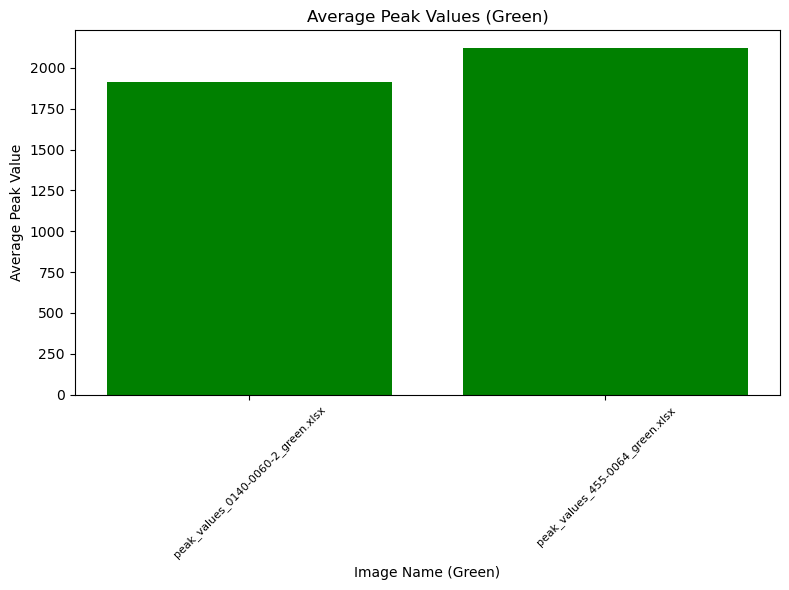

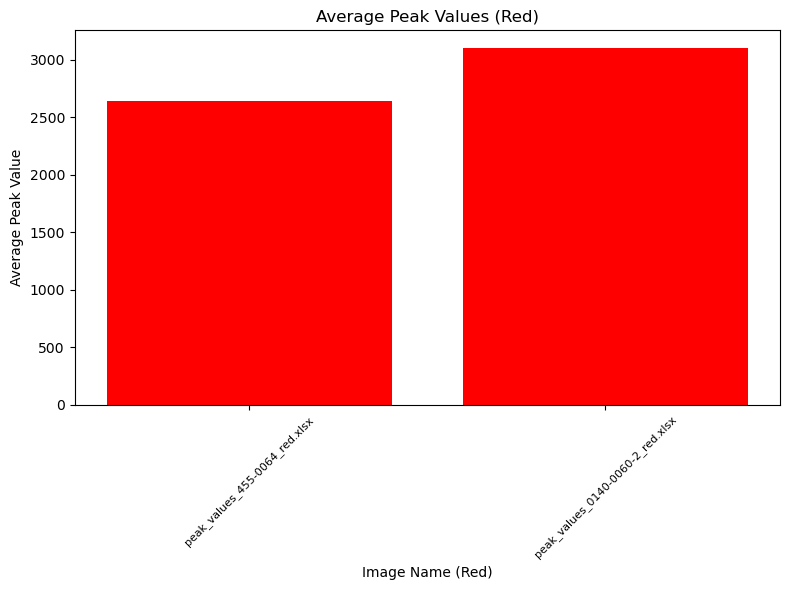

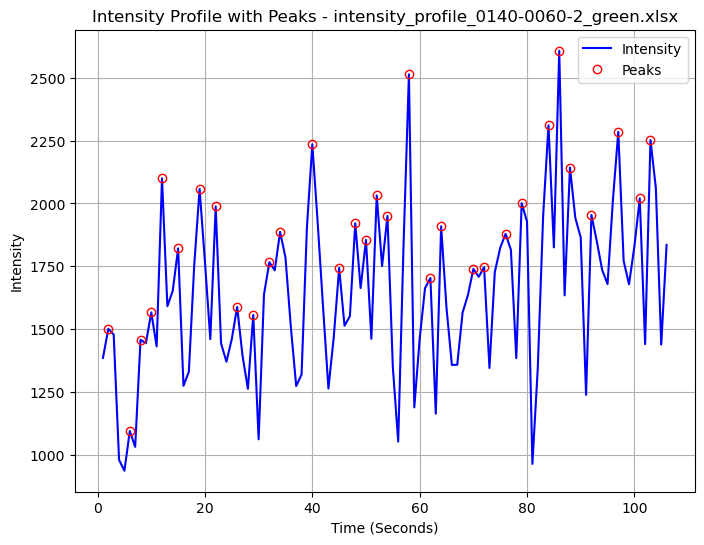

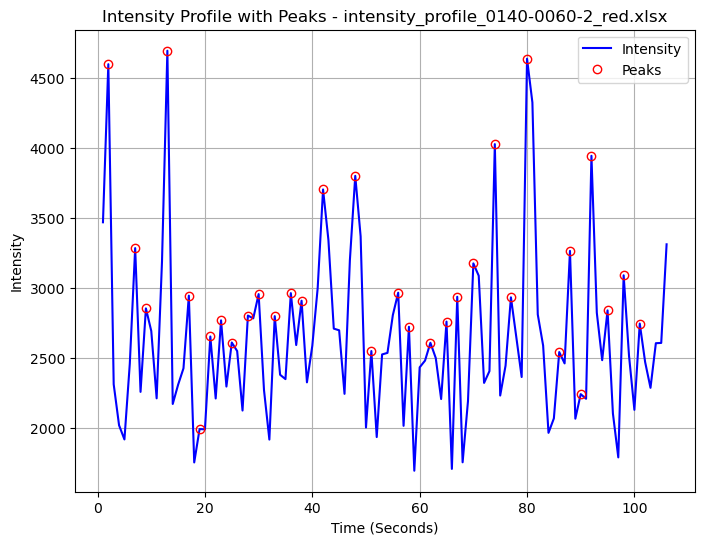

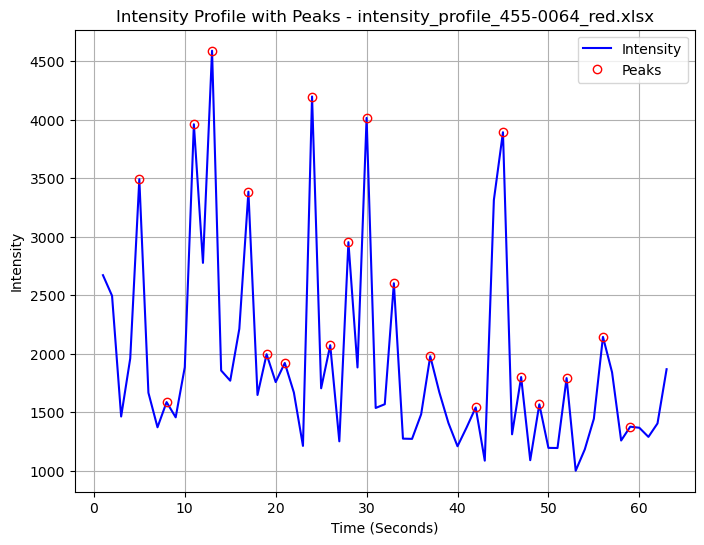

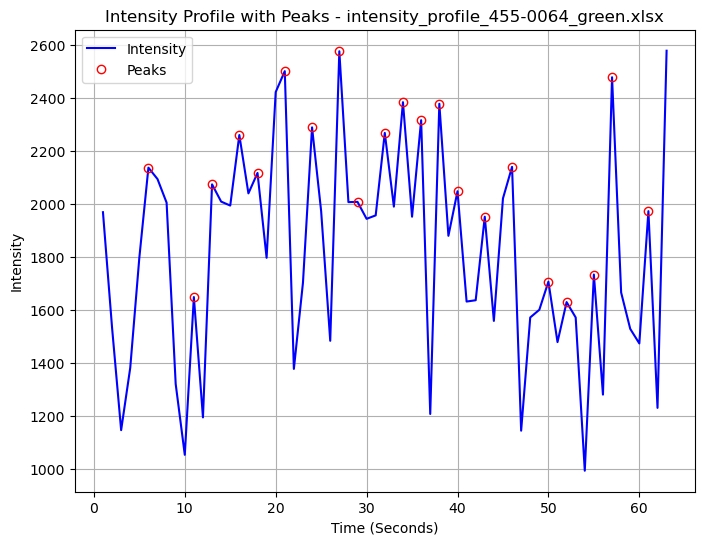

In [3]:
# to find peak
from scipy.signal import find_peaks
from matplotlib.patches import Circle
import os
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import matplotlib.pyplot as plt

# Use tkinter to select the folder containing the files
root = tk.Tk()
root.withdraw()
input_folder = filedialog.askdirectory(title="Select Folder with Analysis Files")

if not input_folder:
    print("No folder selected. Exiting...")
    exit()

# Create a folder to save the plots
plots_folder = os.path.join(input_folder, "plots")
os.makedirs(plots_folder, exist_ok=True)

# Open the peak-values folder and calculate the average of the Peak Intensity column
peak_values_folder = os.path.join(input_folder, "peak-values")

# Lists to store the data for green and red plots
green_data = []
red_data = []

for filename in os.listdir(peak_values_folder):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(peak_values_folder, filename)
        df = pd.read_excel(file_path)  # Read the Excel file

        # Calculate the average of the Peak Intensity column
        avg_peak = df["Peak Intensity"].mean()

        # Determine whether it's a green or red file based on the filename
        if "green" in filename.lower():
            green_data.append((filename, avg_peak))
        elif "red" in filename.lower():
            red_data.append((filename, avg_peak))

# Create bar plots for green and red data
if green_data:
    green_files, green_values = zip(*green_data)
    plt.figure(figsize=(8, 6))
    plt.bar(green_files, green_values, color='green')
    plt.xlabel('Image Name (Green)')
    plt.ylabel('Average Peak Value')
    plt.title('Average Peak Values (Green)')
    plt.xticks(rotation=45, fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_folder, "average_peak_values_green.png"))

if red_data:
    red_files, red_values = zip(*red_data)
    plt.figure(figsize=(8, 6))
    plt.bar(red_files, red_values, color='red')
    plt.xlabel('Image Name (Red)')
    plt.ylabel('Average Peak Value')
    plt.title('Average Peak Values (Red)')
    plt.xticks(rotation=45, fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_folder, "average_peak_values_red.png"))

# Create an Excel file to store the average peak data in separate sheets
output_excel_path = os.path.join(input_folder, "average_peak_values.xlsx")
with pd.ExcelWriter(output_excel_path, engine="xlsxwriter") as writer:
    if green_data:
        green_df = pd.DataFrame(green_data, columns=["Image Name (Green)", "Average Peak Value"])
        green_df.to_excel(writer, sheet_name="Green Data", index=False)

    if red_data:
        red_df = pd.DataFrame(red_data, columns=["Image Name (Red)", "Average Peak Value"])
        red_df.to_excel(writer, sheet_name="Red Data", index=False)
# Now, add code to create a copy of each intensity plot with peak intensities marked
intensity_profiles_folder = os.path.join(input_folder, "intensity-profile")

for filename in os.listdir(intensity_profiles_folder):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(intensity_profiles_folder, filename)
        df = pd.read_excel(file_path)  # Read the intensity profile data

        # Extract x and y values
        x_values = df["Time (Seconds)"]
        y_values = df["Intensity"]

        # Find peaks in the intensity profile
        peaks, _ = find_peaks(y_values, height=0)

        # Create a copy of the intensity plot with peaks marked using red hollow circles
        plt.figure(figsize=(8, 6))
        plt.plot(x_values, y_values, color='blue', label='Intensity')
        plt.plot(x_values[peaks], y_values[peaks], 'ro', label='Peaks', fillstyle='none')
        plt.xlabel('Time (Seconds)')
        plt.ylabel('Intensity')
        plt.title(f'Intensity Profile with Peaks - {filename}')
        plt.legend()
        plt.grid(True)

        # Save the marked intensity plot as an image
        plot_filename = os.path.splitext(filename)[0] + "_with_peaks.png"
        plot_path = os.path.join(plots_folder, plot_filename)
        plt.savefig(plot_path)

print("Analysis completed!")


In [16]:
import os
import tkinter as tk
from tkinter import filedialog
import pandas as pd

# Use tkinter to select the folder containing the files
root = tk.Tk()
root.withdraw()
input_folder = filedialog.askdirectory(title="Select Folder with Kymographs")

if not input_folder:
    print("No folder selected. Exiting...")
    exit()

# Define the input and output file paths
input_file_path = os.path.join(input_folder, "all_trajectories.xlsx")
output_green_file_path = os.path.join(input_folder, "green_all_trajectories.xlsx")
output_red_file_path = os.path.join(input_folder, "red_all_trajectories.xlsx")

# Read the input Excel file without converting the first row to column names
xls = pd.ExcelFile(input_file_path)

# Initialize DataFrames for green and red trajectories
green_trajectories = {}
red_trajectories = {}

# Iterate through sheet names and filter green and red trajectories
for sheet_name in xls.sheet_names:
    if sheet_name.lower().endswith("green"):
        green_trajectories[sheet_name] = pd.read_excel(xls, sheet_name=sheet_name, header=None)
    elif sheet_name.lower().endswith("red"):
        red_trajectories[sheet_name] = pd.read_excel(xls, sheet_name=sheet_name, header=None)

# Write green trajectories to a new Excel file
with pd.ExcelWriter(output_green_file_path, engine="xlsxwriter") as writer:
    for sheet_name, df in green_trajectories.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False, header=None)

# Write red trajectories to a new Excel file
with pd.ExcelWriter(output_red_file_path, engine="xlsxwriter") as writer:
    for sheet_name, df in red_trajectories.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False, header=None)

print("Extraction completed!")


2023-10-11 23:46:38.001 python[3200:1796011] +[CATransaction synchronize] called within transaction
2023-10-11 23:46:38.043 python[3200:1796011] +[CATransaction synchronize] called within transaction
2023-10-11 23:46:38.092 python[3200:1796011] +[CATransaction synchronize] called within transaction
2023-10-11 23:46:41.812 python[3200:1796011] +[CATransaction synchronize] called within transaction


Extraction completed!


In [29]:
# This is for exporting both average and maximum peak intensity values
# Import necessary libraries
import os
import tkinter as tk
from tkinter import filedialog
import pandas as pd

# Use tkinter to select the folder containing the files
root = tk.Tk()
root.withdraw()
input_folder = filedialog.askdirectory(title="Select Folder with Analysis Files")

if not input_folder:
    print("No folder selected. Exiting...")
    exit()

# Create a folder to save the Excel file
output_excel_path = os.path.join(input_folder, "average_max_peak_values.xlsx")

# Open the peak-values folder and calculate the average and max of the Peak Intensity column
peak_values_folder = os.path.join(input_folder, "peak-values")

# Lists to store the data for green and red files
green_data = []
red_data = []

# Dictionary to store max peak intensity values for each file
max_intensity_data = {}

for filename in os.listdir(peak_values_folder):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(peak_values_folder, filename)
        df = pd.read_excel(file_path)  # Read the Excel file

        # Calculate the average and max of the Peak Intensity column
        avg_peak = df["Peak Intensity"].mean()
        max_peak = df["Peak Intensity"].max()

        # Determine whether it's a green or red file based on the filename
        if "green" in filename.lower():
            green_data.append((filename, avg_peak, max_peak))
        elif "red" in filename.lower():
            red_data.append((filename, avg_peak, max_peak))

# Create DataFrames for green and red data
if green_data:
    green_df = pd.DataFrame(green_data, columns=["Image Name (Green)", "Average Peak Value", "Max Peak Value"])
if red_data:
    red_df = pd.DataFrame(red_data, columns=["Image Name (Red)", "Average Peak Value", "Max Peak Value"])

# Create an Excel file to store the average and max peak data in separate sheets
with pd.ExcelWriter(output_excel_path, engine="xlsxwriter") as writer:
    if green_data:
        green_df.to_excel(writer, sheet_name="Green Data", index=False)
    if red_data:
        red_df.to_excel(writer, sheet_name="Red Data", index=False)

print("Average and Maximum Peak Values exported to 'average_max_peak_values.xlsx'.")


2023-10-16 23:08:15.093 python[14199:509553] +[CATransaction synchronize] called within transaction
2023-10-16 23:08:15.130 python[14199:509553] +[CATransaction synchronize] called within transaction
2023-10-16 23:08:15.184 python[14199:509553] +[CATransaction synchronize] called within transaction
2023-10-16 23:08:18.550 python[14199:509553] +[CATransaction synchronize] called within transaction


Average and Maximum Peak Values exported to 'average_max_peak_values.xlsx'.
